# ACUITY ANALYTICS  
### Data Science Challenge

---

Welcome to this notebook, which presents my end-to-end approach to the Acuity Analytics Data Science Challenge.

The notebook is structured to reflect a realistic data science workflow. It begins with an Exploratory Data Analysis (EDA), a crucial step for understanding the data, identifying patterns, and uncovering potential issues before modeling. Insights gained during the EDA directly inform the design of the predictive maintenance solution that follows.

Building on these insights, I then develop and evaluate a predictive maintenance approach, explaining key modeling decisions and assumptions along the way. Interpretations of results, theoretical considerations, and reasoning behind methodological choices are documented directly within the code comments.

The concrete answers to the challenge questions are provided toward the end of the notebook, followed by a summary of findings and conclusions.

### load required packages:

In [186]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go #for interactive plots

from plotly.subplots import make_subplots

from scipy.stats import linregress

import matplotlib.pyplot as plt #specifically required for autocorrelation plot
from pandas.plotting import autocorrelation_plot

### load data 

In [187]:
df_data = pd.read_csv("Ascent_DS_Challenge_Data_set.csv")

# Exploratory Data Analysis (EDA)

- **ASSUMPTION** data is collected before dance-off: meaning that day one: batterylfie 5.6 no full charge -> enough for a dance-off
- "data is in chronological order (old to new) -> gives a hint: data is of time series" -> classical statistical assumptions do not hold (such as iid <=> independent and identically distributed)
- Due to time-series data: check also rolling statistics in the data to get a trend


### Get overview of the data
- check for potential missing data 
- mean/std should not be considered important as time-series data change over time (therefore we use rolling stats later)

In [188]:
df_data.describe()

,ChargingTime,FullCharge,BatteryLife,Capacity drop
count,100.000000,100.000000,100.000000,100.000000
mean,4.573000,0.540000,5.167347,0.213125
std,2.788603,0.500908,1.750706,0.039452
min,0.000000,0.000000,0.000000,0.000000
25%,1.987500,0.000000,3.975000,0.209650
50%,4.375000,1.000000,6.129550,0.224000
75%,6.522500,1.000000,6.250025,0.232500
max,11.720000,1.000000,8.000000,0.240200


### Check correlations

In [189]:
# check potential linear correlations (pearson)
print("Pearson")
display(df_data.corr("pearson"))
# check potential rank-based correlations (spearman) if potentially no linear correlations can be found
print("Spearman")
display(df_data.corr("spearman"))

Pearson


,ChargingTime,FullCharge,BatteryLife,Capacity drop
ChargingTime,1.000000,0.838968,0.772428,-0.019829
FullCharge,0.838968,1.000000,0.696445,0.027576
BatteryLife,0.772428,0.696445,1.000000,-0.162551
Capacity drop,-0.019829,0.027576,-0.162551,1.000000


Spearman


,ChargingTime,FullCharge,BatteryLife,Capacity drop
ChargingTime,1.000000,0.863303,0.764691,-0.058015
FullCharge,0.863303,1.000000,0.712466,-0.061863
BatteryLife,0.764691,0.712466,1.000000,-0.431366
Capacity drop,-0.058015,-0.061863,-0.431366,1.000000


### Findings:
- (Linear) correlations found between ChargingTime and FullCharge -> longer charging time - if fullCharge also straightforward
- (Linear) correlations found between ChargingTime and BatteryLife -> longer charging time - higher BatteryLife which makes sense.
- Some negative relationship (non-linear) between BatteryLife and Capacity drop: higher capacity drop means lover battery Life -> also logical, the less capacity remaining the lower the battery life as it cannot be fully charged

### First data visualization:
- dotted black line shows minimal battery life required to perform a dance-off

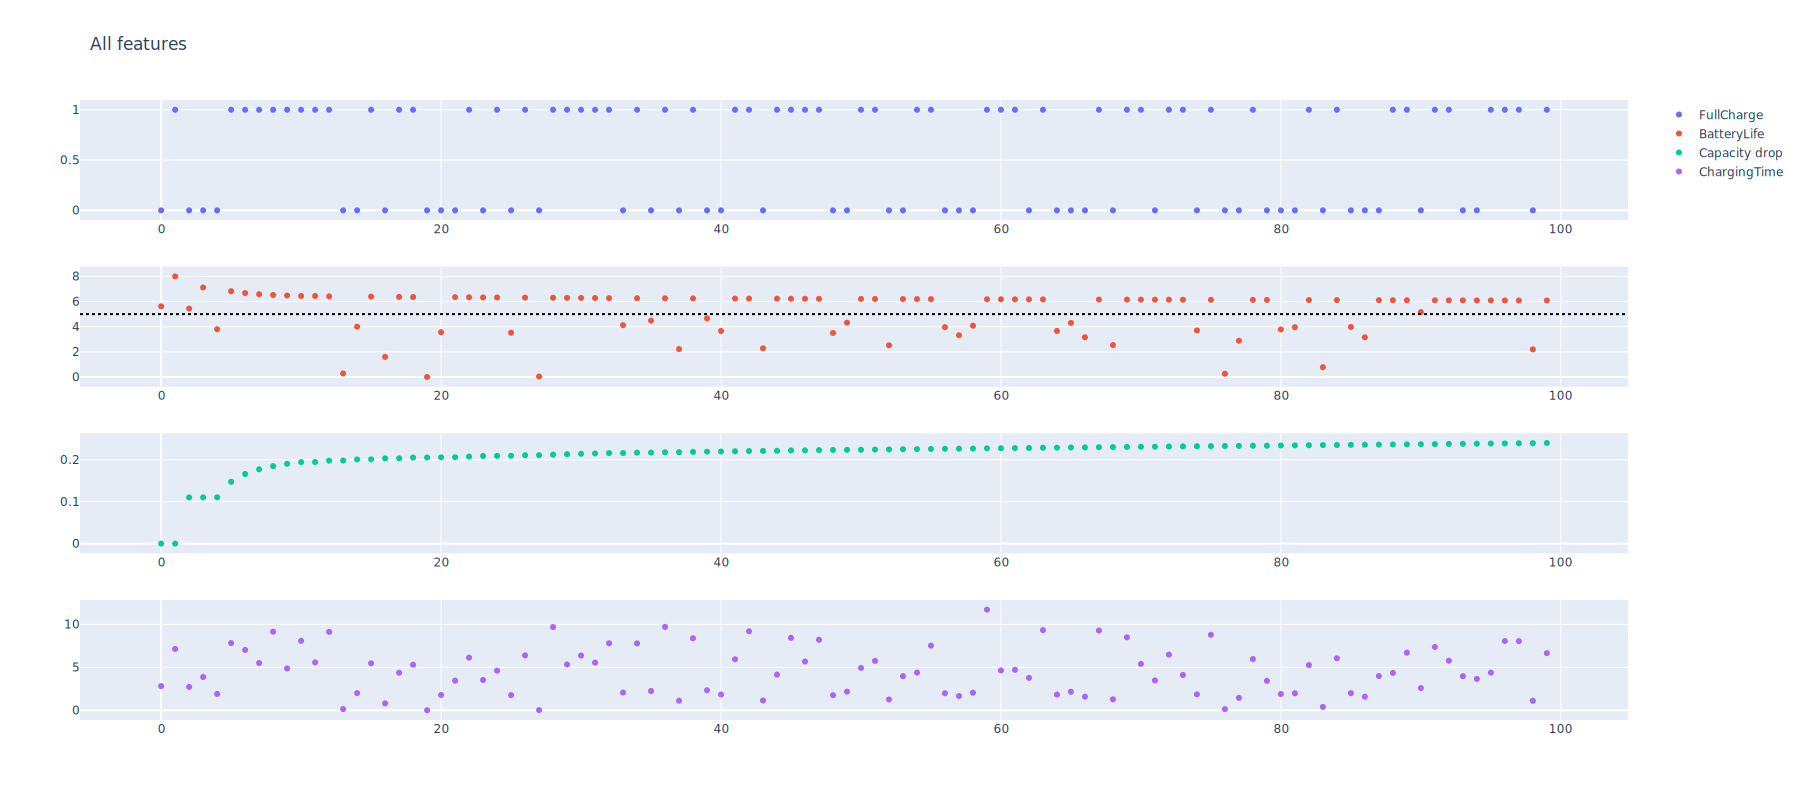

In [190]:
def create_subplots(df, str_title="", b_longevity=False) -> go.Figure:
    
    str_subplot_mode = "markers"
    fig = make_subplots(rows=4, cols=1)

    str_row_3_key = "Capacity drop" if not b_longevity else "longevity"

    fig.add_trace(
        go.Scatter(y=df["FullCharge"], name="FullCharge", mode=str_subplot_mode),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(y=df["BatteryLife"], name="BatteryLife", mode=str_subplot_mode),
        row=2, col=1
    )

    fig.add_hline(
    y=5, 
    line_width=2, 
    line_dash="dot", 
    line_color="#000000",
    row=2, col=1)
    

    fig.add_trace(
        go.Scatter(y=df[str_row_3_key],name=str_row_3_key, mode=str_subplot_mode),
        row=3, col=1
    )

    fig.add_trace(
        go.Scatter(y=df["ChargingTime"],name="ChargingTime", mode=str_subplot_mode),
        row=4, col=1
    )
    fig.update_layout( title_text=str_title)
    
    return fig


fig = create_subplots(df_data, "All features")


fig.show("svg",height=800, width=1800,scale=1) #required to be visible on github -> interaction goes lost

### Finding:
- Second day: **fullCharge = 1** and **BatteryLife = 8** and **Capacity drop = 0** meaning that this is the first full charge and the battery is completely healthy and holds a maximum capactiy that enables a battery life of 8h (more is not possible and will not be in the future since the capacity dropss. 
- At least 5 hours are required to performa a dance-off, the capacity drop is 0.24 at **day 100**, at least ~6 hours are max left on the battery
- Battery capacity drop slows down after inital drop, tends to become 
linear with a small slope 

### Adding features: 
- day (to better get time-dependent correlations) 
- longevity (instead of capacity drop -> easier to interpret for the solution)

In [191]:
# add longevity instead of CapacityDrop - for easier interpretation
df_data["longevity"] = 1 - df_data["Capacity drop"]
df_data["day"] = np.arange(len(df_data))

### Again check correlations:
- assumption: feature reduncay, check which features highly correlate, potentially remove than as it may confuse any further model since no new information is encoded

In [192]:
# check potential linear correlations (pearson)

print("Pearson")
display(df_data.corr("pearson"))
# check potential rank-based correlations (spearman) if potentially no linear correlations can be found
print("Spearman")
display(df_data.corr("spearman"))


Pearson


,ChargingTime,FullCharge,BatteryLife,Capacity drop,longevity,day
ChargingTime,1.000000,0.838968,0.772428,-0.019829,0.019829,-0.051101
FullCharge,0.838968,1.000000,0.696445,0.027576,-0.027576,-0.061862
BatteryLife,0.772428,0.696445,1.000000,-0.162551,0.162551,-0.078946
Capacity drop,-0.019829,0.027576,-0.162551,1.000000,-1.000000,0.667773
longevity,0.019829,-0.027576,0.162551,-1.000000,1.000000,-0.667773
day,-0.051101,-0.061862,-0.078946,0.667773,-0.667773,1.000000


Spearman


,ChargingTime,FullCharge,BatteryLife,Capacity drop,longevity,day
ChargingTime,1.000000,0.863303,0.764691,-0.058015,0.058015,-0.058105
FullCharge,0.863303,1.000000,0.712466,-0.061863,0.061863,-0.061862
BatteryLife,0.764691,0.712466,1.000000,-0.431366,0.431366,-0.431501
Capacity drop,-0.058015,-0.061863,-0.431366,1.000000,-1.000000,0.999994
longevity,0.058015,0.061863,0.431366,-1.000000,1.000000,-0.999994
day,-0.058105,-0.061862,-0.431501,0.999994,-0.999994,1.000000


### Findings:
- strong relationship between day and longevity accordig to Spearman --> this means the added freature day does not add any new information and could be removed again
- (linear) relationship between BatteryLife and charging time: longer charging time means longer battery life.

### EDA specific for time-series data:
- Check autocorrelation: check how much the past influences the present (lag: day in the past, lag=1 one day, lag=2 two days,...)

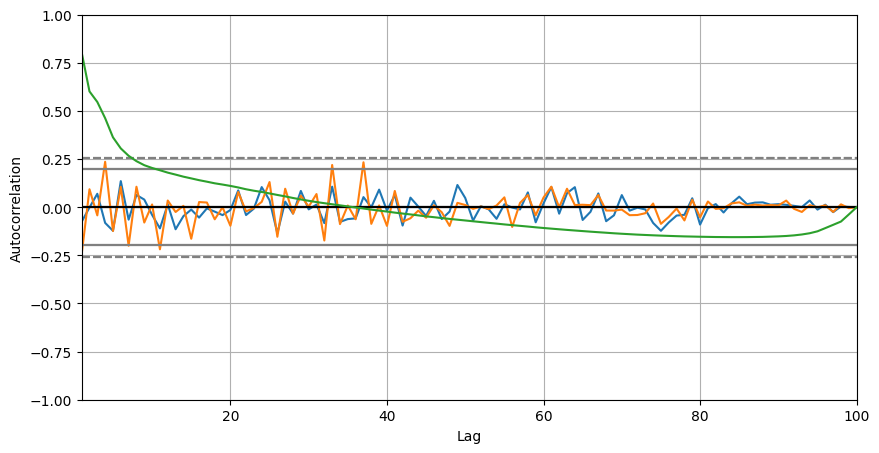

In [193]:


plt.figure(figsize=(10, 5))
li_keys = ["BatteryLife", "ChargingTime","longevity"]
for str_key in li_keys:
    autocorrelation_plot(df_data[str_key])

### Autocorrelation plot:
- does not show any new details. just the small lags for the green line (longevity) do show signs of high correlation (meaning that this a value from yesterday highly influences the present day). Makes sense since the value is accumulative, as described. For the other features, the autocorrelation is around 0, not much info to gain here.

### Rolling statistics: smoothing the data to unveil trends

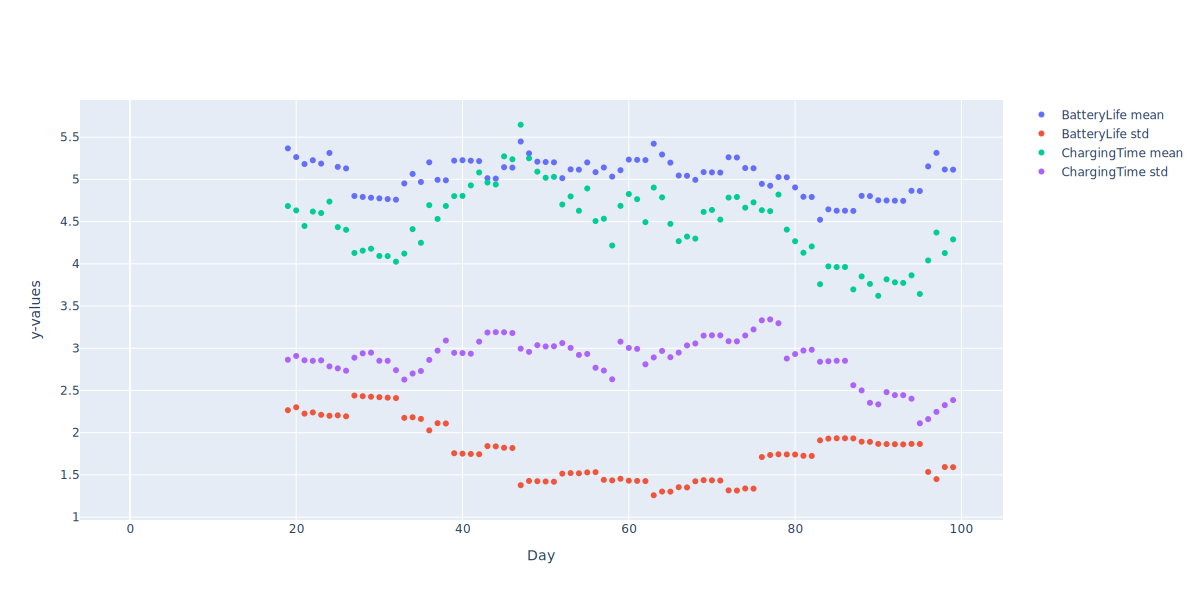

In [194]:
fig = go.Figure()
str_key = "Capacity drop"
str_key = "ChargingTime"
#str_key = "BatteryLife"

n_window = 20
fig.add_trace(go.Scatter(y=df_data["BatteryLife"].rolling(window=n_window).mean(),mode="markers", name="BatteryLife mean"))
fig.add_trace(go.Scatter(y=df_data["BatteryLife"].rolling(window=n_window).std(),mode="markers", name="BatteryLife std"))

fig.add_trace(go.Scatter(y=df_data["ChargingTime"].rolling(window=n_window).mean(),mode="markers", name="ChargingTime mean"))
fig.add_trace(go.Scatter(y=df_data["ChargingTime"].rolling(window=n_window).std(),mode="markers", name="ChargingTime std"))


#fig.update_layout(legend_title_text = "Contestant")
fig.update_xaxes(title_text="Day")
fig.update_yaxes(title_text="y-values")

fig.show("svg", width=1200, height=600, scale=1) #required to be visible on github -> interaction goes lost


### Findings: 
- only Battery life and Charging time displayed since the data shows fluctuations compared to capacity life (or longevity)
- both std are not steady even for larger windows such as 10 or 20
- conclusion: no clear trend visible in Charging time as well as in BatteryLife. 

### Check full charges only
- black dashed line: minimum batterLife required for performing a dance-off.
- this time using the longevity instead of Capacity drop
- only full charges to get a clearer image

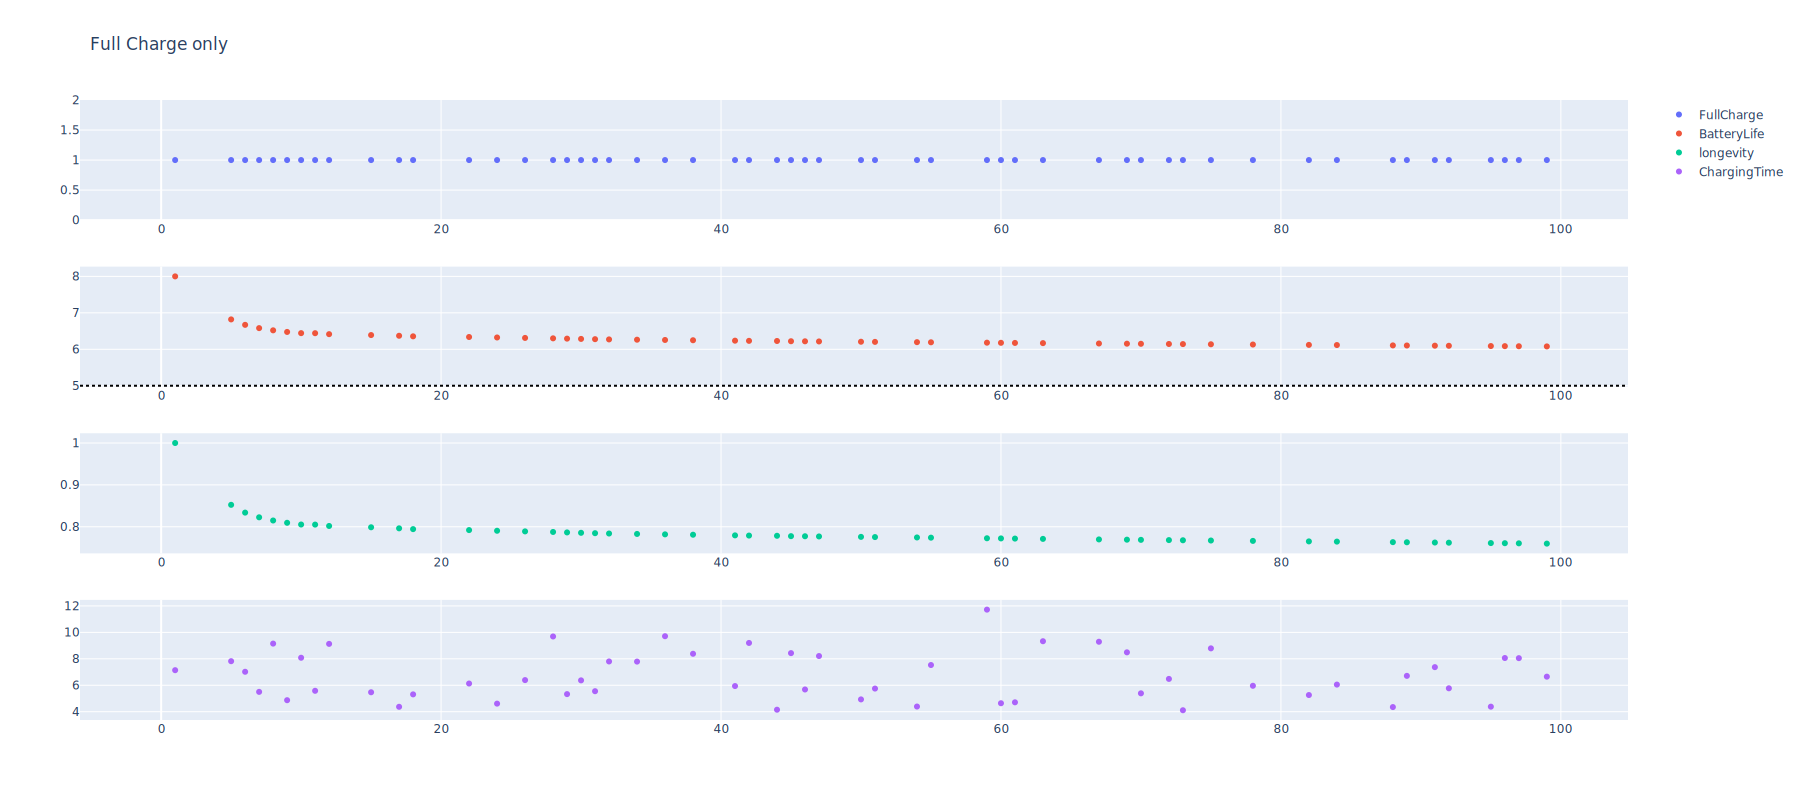

Pearson


,ChargingTime,BatteryLife,Capacity drop,longevity,day
ChargingTime,1.000000,0.052755,-0.052763,0.052763,-0.048535
BatteryLife,0.052755,1.000000,-1.000000,1.000000,-0.652441
Capacity drop,-0.052763,-1.000000,1.000000,-1.000000,0.652524
longevity,0.052763,1.000000,-1.000000,1.000000,-0.652524
day,-0.048535,-0.652441,0.652524,-0.652524,1.000000


Spearman


,ChargingTime,BatteryLife,Capacity drop,longevity,day
ChargingTime,1.000000,0.042729,-0.042729,0.042729,-0.042729
BatteryLife,0.042729,1.000000,-1.000000,1.000000,-1.000000
Capacity drop,-0.042729,-1.000000,1.000000,-1.000000,1.000000
longevity,0.042729,1.000000,-1.000000,1.000000,-1.000000
day,-0.042729,-1.000000,1.000000,-1.000000,1.000000


How many are below 5 hours:  0
How many are above (or equal) 5 hours:  54


In [195]:


df_data_filtered = df_data.where(df_data["FullCharge"] == 1, other=np.nan)

fig = create_subplots(df_data_filtered, str_title="Full Charge only", b_longevity=True)
fig.show("svg",height=800, width=1800,scale=1) #required to be visible on github -> interaction goes lost

# check stats with only fully charged batteries
df_data_filtered_stats = df_data[df_data["FullCharge"] == 1]
print("Pearson")
display(df_data_filtered_stats.drop(columns=['FullCharge']).corr("pearson"))
print("Spearman")
display(df_data_filtered_stats.drop(columns=['FullCharge']).corr("spearman"))

print("How many are below 5 hours: ",df_data_filtered[df_data_filtered["BatteryLife"]<5].count().iloc[0])
print("How many are above (or equal) 5 hours: ",df_data_filtered[df_data_filtered["BatteryLife"]>=5].count().iloc[0])




### Findings
- one can see that if only considered full charges: Battery life and longevity behave similiar: Both strongly decrease at the beginning and later the decrease slows down (in a linear behaviour), but does not stop!
- Battery life always over 6 hours when fully charged: no problem for a dance-off (minimum of 5 always exceeded)
- Conclusion: one can see when the only considered full charges, batterLife and longevity strongly correlate which makes sense: lower longevity means shorter BatterLife 

### Check no full charge only
- black dashed line: minimum batterLife required for performing a dance-off.

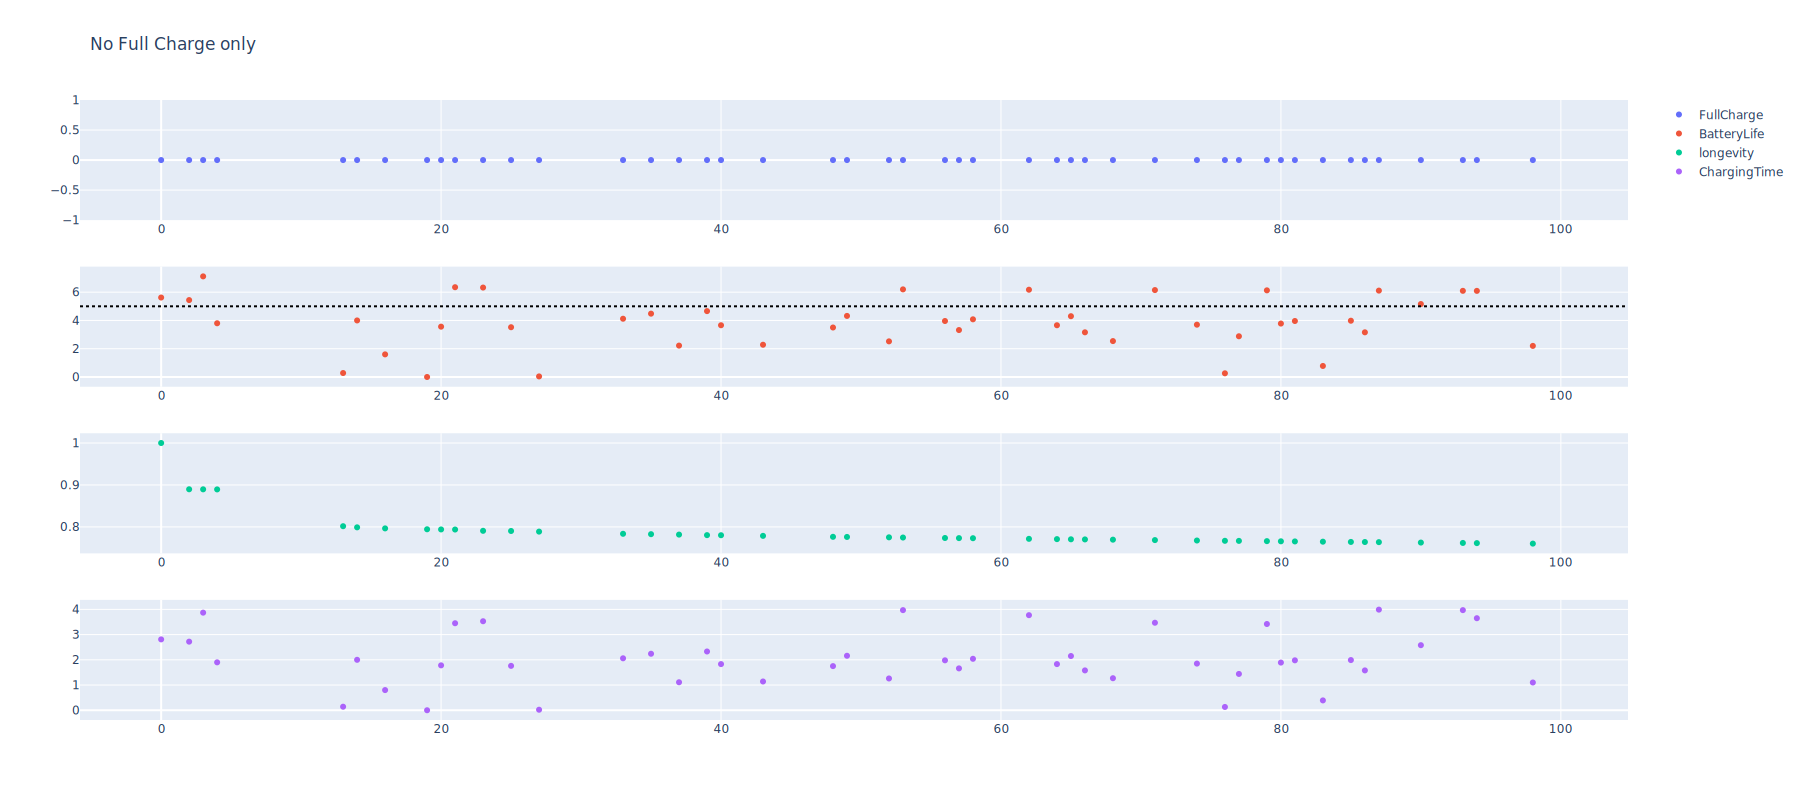

Pearson


,ChargingTime,BatteryLife,Capacity drop,longevity,day
ChargingTime,1.000000,0.981546,-0.132019,0.132019,0.099649
BatteryLife,0.981546,1.000000,-0.195211,0.195211,0.044500
Capacity drop,-0.132019,-0.195211,1.000000,-1.000000,0.697976
longevity,0.132019,0.195211,-1.000000,1.000000,-0.697976
day,0.099649,0.044500,0.697976,-0.697976,1.000000


Spearman


,ChargingTime,BatteryLife,Capacity drop,longevity,day
ChargingTime,1.000000,0.987879,0.063344,-0.063344,0.063344
BatteryLife,0.987879,1.000000,0.001727,-0.001727,0.001727
Capacity drop,0.063344,0.001727,1.000000,-1.000000,1.000000
longevity,-0.063344,-0.001727,-1.000000,1.000000,-1.000000
day,0.063344,0.001727,1.000000,-1.000000,1.000000


How many are below 5 hours:  33
How many are above (or equal) 5 hours:  13


In [196]:
df_data_filtered = df_data.where(df_data["FullCharge"] == 0, other=np.nan)

fig = create_subplots(df_data_filtered, str_title="No Full Charge only", b_longevity=True)
fig.show("svg",height=800, width=1800,scale=1) #required to be visible on github -> interaction goes lost

# check stats with only fully charged batteries
df_data_filtered_stats = df_data[df_data["FullCharge"] == 0]
print("Pearson")
display(df_data_filtered_stats.drop(columns=['FullCharge']).corr("pearson"))
print("Spearman")
display(df_data_filtered_stats.drop(columns=['FullCharge']).corr("spearman"))

print("How many are below 5 hours: ",df_data_filtered[df_data_filtered["BatteryLife"]<5].count().iloc[0])
print("How many are above (or equal) 5 hours: ",df_data_filtered[df_data_filtered["BatteryLife"]>=5].count().iloc[0])



### Findings:
- longevity and batterlife do not follow the same pattern (makes sense since battery is not fullychared to the capacity max)
- Longevity and battery life do not follow the same pattern, which is expected since the battery is not always charged to its maximum capacity.
- There are 33 instances where the battery life is below 5; in all of these cases, the robot is unable to perform a dance-off, potentially resulting in penalties.
- There are 13 instances where the robot is not fully charged but still has sufficient battery life (≥ 5) to perform a dance-off.
- Out of 100 total days, all 33 days with battery life below 5 occurred only when the robot was not fully charged.
- There was not a single instance where battery life dropped below 5 while the robot was fully charged.

- Table of summary: 

| Battery condition | Fully charged = 1 | Fully charged = 0 | Row sum |
|-------------------|-------------------|-------------------|---------|
| batteryLife ≥ 5   | 54                | 13                | 67      |
| batteryLife < 5   | 0                 | 33                | 33      |
| **Column sum**    | **54**            | **46**            | **100** |

Conditional prob: P(FullyCharged=1 ∣ batteryLife ≥ 5)= 54/67 ​≈0.806 => About 80.6% of the time, having enough battery life coincided with the robot being fully charged. About 19.4% of the time, the robot had enough battery life despite not being fully charged. In a nutshell: full charges appear to be the better solution.

#### **Recommendation: Always fully charge the robot before a dance-off to avoid insufficient battery life and prevent penalties from the committee.**


# Predictive Maintenance 

- Is done to predict when the maintenance is due.
- Predictions should be considered dangerous, as no ground truth is yet available; therefore, they should be taken with a grain of salt.
- According to some internet research, near the end of a battery’s life there is a significant drop in longevity. However, since the prerequisite is that longevity remains above 70%, extrapolation can still be useful.
- This simple dataset does not require a sophisticated machine learning algorithm: rather a straightforward linear regression is sufficient.
- After the initial decline, the longevity data appears to be linear. Therefore, it is assumed that a linear regression model is an appropriate choice to model this behavior.
- A linear model is fitted on  x = days and  y = longevity (only from day 50 onwords).


In [197]:
def fit_predict(x, y) -> list: 
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    print(f"linear equation: {p}")
    li_xvals = np.arange(100,350)

    return p(li_xvals)

# using full and non-full charges:
mask = df_data["day"] >= 49 #50 days -> 49 since we start with day = 0
df_selected = df_data[mask]

y_pred = fit_predict(df_selected["day"], df_selected["longevity"])



linear equation:  
-0.0003229 x + 0.7917


### Plot the linear extrapolation:
- iteratevly extend the x data until the line crosses 0.7 (the minimum longevity accroding to the CRD)

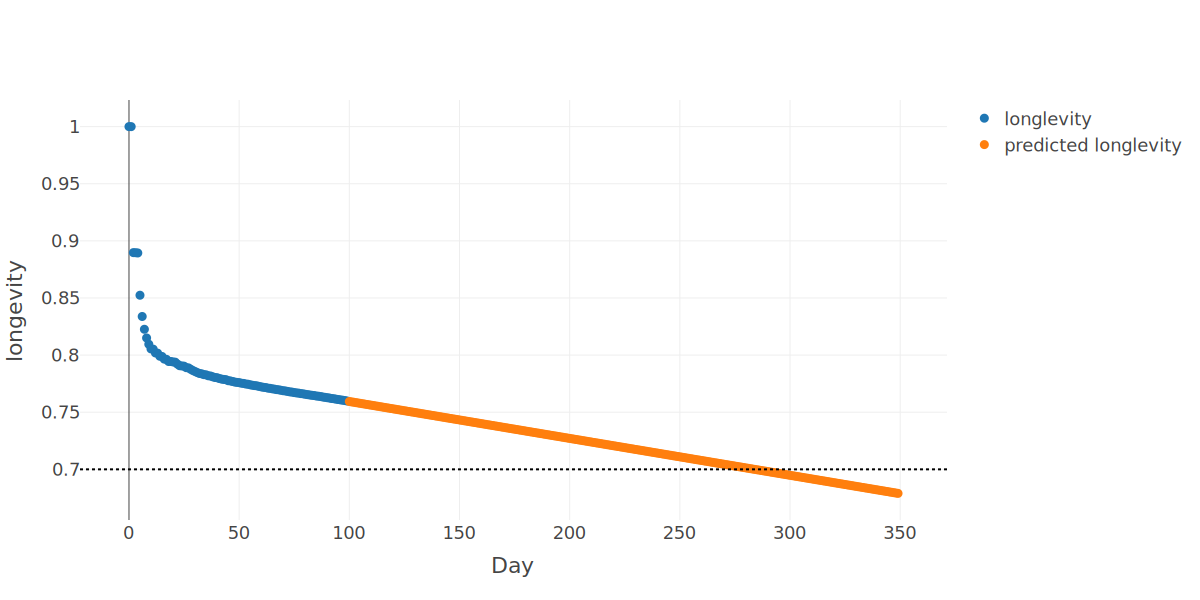

In [198]:
fig = go.Figure()

str_key = "longevity" 
fig.add_trace(go.Scatter(x=df_data["day"],y=df_data["longevity"],mode="markers",name="longlevity"))
fig.add_trace(go.Scatter(x=np.arange(100,100+len(y_pred)),y=y_pred,mode="markers",name="predicted longlevity"))


fig.add_hline(
    y=0.7, 
    line_width=2, 
    line_dash="dot", 
    line_color="#000000",
    row=1, col=1
)

fig.update_xaxes(title_text="Day")
fig.update_yaxes(title_text=str_key)
fig.update_layout(
    template="presentation",
)
fig.show("svg", width=1200, height=600, scale=1) #required to be visible on github -> interaction goes lost

### Find the best cut off where longevity could be considered linear.
- The code in the cell below that minimizes the R² during linear fit is completely coded by Gemini!

Optimal Linear Start Index: 65
Max R^2 Score: 0.9996


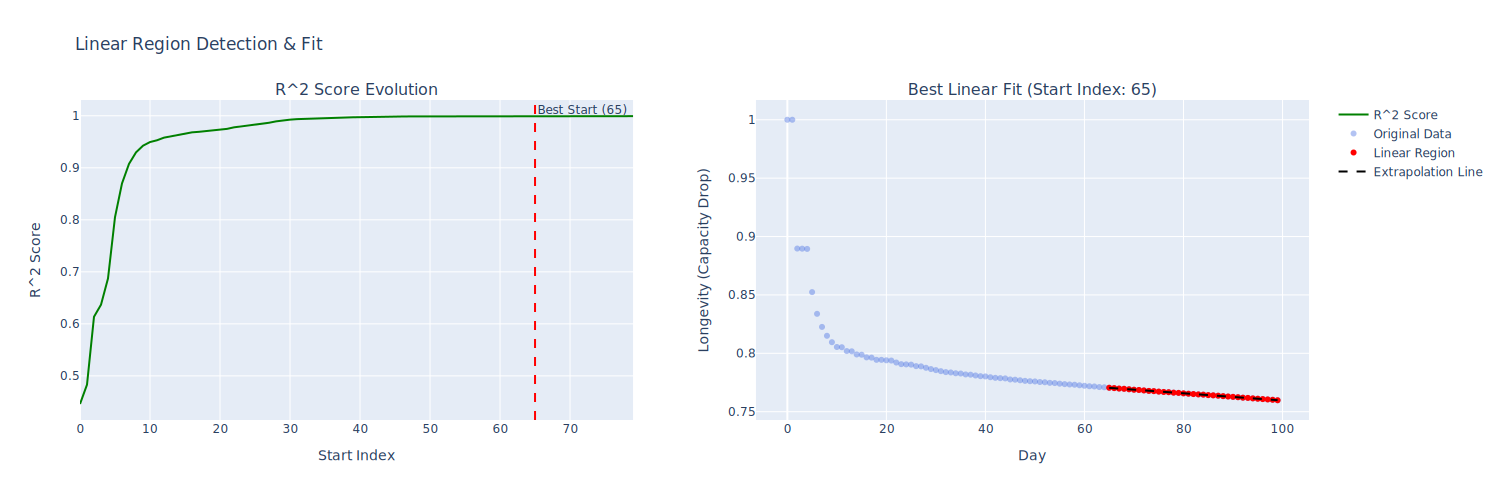

In [199]:

def find_best_linear_start(df, x_col, y_col, min_points=20):
    """
    Iterates through the data to find the start index that maximizes R^2 
    for a linear regression on the remaining tail.
    """
    
    # Ensure data is sorted by day
    df = df.sort_values(by=x_col).reset_index(drop=True)
    
    best_r2 = -np.inf
    best_start_idx = 0
    best_params = (0, 0) # Slope, Intercept
    
    # Store history to plot later
    r2_history = []
    indices = []

    # We stop when we have fewer than 'min_points' left
    # (Fitting a line to 2 points is meaningless)
    max_start = len(df) - min_points
    
    for i in range(max_start):
        # Select the segment from i to the end
        x_segment = df[x_col].iloc[i:]
        y_segment = df[y_col].iloc[i:]
        
        # specific check: if variance is 0 (flat line), correlation is defined as 0 or nan
        if np.std(y_segment) == 0:
            r2 = 0
        else:
            # Calculate Linear Regression
            slope, intercept, r_value, p_value, std_err = linregress(x_segment, y_segment)
            r2 = r_value ** 2
        
        r2_history.append(r2)
        indices.append(i)
        
        # Update best found so far
        if r2 > best_r2:
            best_r2 = r2
            best_start_idx = i
            best_params = (slope, intercept)

    return best_start_idx, best_r2, best_params, indices, r2_history

# --- Usage Example ---

df =df_data

# 2. Run the function
best_idx, max_r2, params, idx_list, r2_list = find_best_linear_start(df, 'day', 'longevity')


print(f"Optimal Linear Start Index: {best_idx}")
print(f"Max R^2 Score: {max_r2:.4f}")


# Create a subplot figure with 1 row and 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("R^2 Score Evolution", f"Best Linear Fit (Start Index: {best_idx})")
)

# --- Plot 1: R^2 Score Evolution ---
# The Line Plot
fig.add_trace(
    go.Scatter(
        x=idx_list, 
        y=r2_list, 
        mode='lines', 
        name='R^2 Score', 
        line=dict(color='green')
    ),
    row=1, col=1
)

# The Vertical Line indicating Best Index
fig.add_vline(
    x=best_idx, 
    line_width=2, 
    line_dash="dash", 
    line_color="red", 
    annotation_text=f"Best Start ({best_idx})", 
    annotation_position="top right",
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df['day'], 
        y=df['longevity'], 
        mode='markers', 
        name='Original Data',
        marker=dict(color='royalblue', opacity=0.4, size=6)
    ),
    row=1, col=2
)

linear_x = df['day'][best_idx:]
linear_y = df['longevity'][best_idx:]

fig.add_trace(
    go.Scatter(
        x=linear_x, 
        y=linear_y, 
        mode='markers', 
        name='Linear Region',
        marker=dict(color='red', size=6)
    ),
    row=1, col=2
)

y_pred = params[0] * linear_x + params[1]

fig.add_trace(
    go.Scatter(
        x=linear_x, 
        y=y_pred, 
        mode='lines', 
        name='Extrapolation Line',
        line=dict(color='black', width=2, dash='dash')
    ),
    row=1, col=2
)

fig.update_layout(
    height=500, 
    width=1500, 
    title_text="Linear Region Detection & Fit",
    showlegend=True
)

fig.update_xaxes(title_text="Start Index", row=1, col=1)
fig.update_yaxes(title_text="R^2 Score", row=1, col=1)
fig.update_xaxes(title_text="Day", row=1, col=2)
fig.update_yaxes(title_text="Longevity (Capacity Drop)", row=1, col=2)

fig.show("svg",scale=1) #required to be visible on github -> interaction goes lost

### Finding: 
- the best fit of a linear regression model starts from day 65

In [200]:
mask = df_data["day"] >= 65
df_selected = df_data[mask]
y_pred_65 = fit_predict(df_selected["day"], df_selected["longevity"])

# get x-max:
x_max = (-0.7  + 0.7906) / 0.0003101
x_max

linear equation:  
-0.0003101 x + 0.7906


292.1638181231861

- given the equation we can calculate the maximum days until we reach a longevity of 0.7:
- According to the calculation, the day on which the minimum is reached would be 292.
---

### Plot of the longevity predcition until day 350

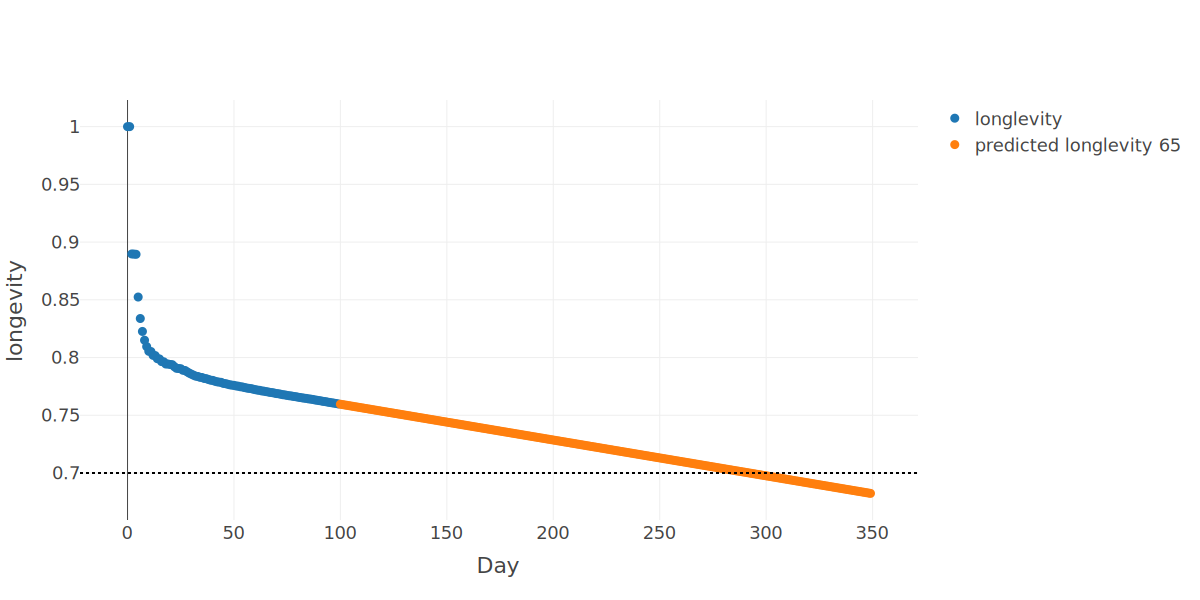

In [201]:
fig = go.Figure()

str_key = "longevity" 
fig.add_trace(go.Scatter(x=df_data["day"],y=df_data["longevity"],mode="markers",name="longlevity"))
fig.add_trace(go.Scatter(x=np.arange(100,100+len(y_pred_65)),y=y_pred_65,mode="markers",name="predicted longlevity 65"))

fig.add_hline(
    y=0.7, 
    line_width=2, 
    line_dash="dot", 
    line_color="#000000",
    row=1, col=1
)
fig.update_xaxes(title_text="Day")
fig.update_yaxes(title_text=str_key)

fig.update_layout(
    template="presentation",
)

fig.show("svg", width=1200, height=600, scale=1) #required to be visible on github -> interaction goes lost

# Final Decision

### 1. Predictive Maintenance

Given the calculation above, assuming that the longevity shows linear behavior from day 65 onwards, we extrapolate until we reach a longevity of 0.7, which corresponds to day 292.  
However, since we did not account for uncertainties (e.g., prediction errors, which tend to increase the further we extrapolate), we conservatively assume this point to be day 290 (to be on the safer side).

Considering the additional constraints—three full weeks required to book the maintenance and one day to charge the battery after assembly—we arrive at a total of **268** days.

In other words, starting from the given data point (day 100), we still have **168** days left before we need to order the battery.

#### Technologies Used
- **pandas** (data management, such as DataFrames and data ingestion)
- **NumPy** (calculations, such as linear regression)
- **SciPy** (linear regression optimization)
- **Plotly** (interactive data visualization)
- **Python virtual environments** (for safe and reproducible deployment, as package versions are frozen)

---

### 2. Presentation of Results and Recommendations

The results and recommendations can be found in the Jupyter notebook, including explanatory comments in the markdown cells.

---

### 3. Quality Assurance & Risk Management

Some risks are already mentioned above and in the code:

- Predicting into the future is inherently risky without ground truth. The pattern may suddenly deviate from linear behavior. To mitigate this, alternative prediction outputs could be presented to the customer, such as confidence intervals for each prediction. These would visually highlight increasing uncertainty the further the prediction extends into the future (funnel-shaped uncertainty).
- Before launching, the model should be validated with ground truth data and thoroughly tested. In high-risk environments, it is essential to verify that all Python packages behave as expected and deliver correct results.

The linear behavior might change after day 100; however, this is beyond our current knowledge. Further research on battery lifetime could improve the model. This would require additional information, such as:
- the type of battery,
- the temperature at which the battery is stored,
- usage and charging patterns.

Gathering this information would allow for more accurate lifetime estimates and more precise predictions.

Another risk is that if we wait too long (i.e., too close to the longevity threshold of 0.7), the battery could experience a sudden drop in longevity (for example, down to 0.68) during a dance battle. This risk should be accounted for and discussed within the team, as it may justify ordering a replacement battery earlier than indicated by the calculations.

**Non-technological risks:**  
Supplier-related issues may arise; for example, a supplier may be unable to deliver the battery due to shortages or political factors. To mitigate this risk, alternative manufacturers should be considered. Ideally, 2–3 suppliers should be evaluated to ensure supply stability.

### Go-Live Considerations
- Add code comments, hints, function descriptions such that the user knows what a function does (depends on the end user)
- Create a clear documentation
- Specify the type of application (web app, standalone application, etc.).
- The number of users who will work with the application must be determined.
- The code developed in the Jupyter notebook must be made runnable as a Python script or, depending on customer preferences, rewritten in another language (e.g., C#, C++, or another language the customer is familiar with), or integrated into an existing system.
- A user interface must be developed, depending on whether the application is a prototype or a production system.
- Data storage must be designed (e.g., database design).
- The system must be thoroughly tested and debugged.
- After testing, the software can be shipped to the customer or deployed using a Docker container (for a web application).

In addition to software-related issues, I would personally test the robots and batteries—at least 2–3 units—until the longevity threshold of 0.7 is reached, in order to obtain ground truth data and improve prediction accuracy.

Furthermore, I would investigate whether different charging patterns could increase battery longevity in the long run.


#